In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import plotly.express as px
import plotly.graph_objs as go
import pickle
from urllib.request import urlopen
import json
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output

# Часть 1. Предобработка данных

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [ ]:
train.shape

(30471, 292)

In [ ]:
def preprocessing_date(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month

    return data

In [ ]:
train = preprocessing_date(train)
test = preprocessing_date(test)

In [ ]:
target = train['price_doc']
id_test = test['id']

Удалим признаки не содержащие информации

In [ ]:
dropped_feat = ['price_doc', 'timestamp', 'id', 'ID_metro', 
                'raion_build_count_with_material_info',
                'raion_build_count_with_builddate_info',
                'ID_railroad_station_walk', "ID_railroad_station_avto",
                "ID_big_road1", "ID_big_road2", "ID_railroad_terminal",
                "ID_bus_terminal"]

In [ ]:
for feat in dropped_feat:
    if feat in test.columns:
        test = test.drop(feat, axis=1)
    train = train.drop(feat, axis=1)

Проверим на наличие пропущеных значений

In [ ]:
train.isna().sum()[train.isna().sum() > 0]

life_sq                         6383
floor                            167
max_floor                       9572
material                        9572
build_year                     13605
num_room                        9572
kitch_sq                        9572
state                          13559
preschool_quota                 6688
school_quota                    6685
hospital_beds_raion            14441
build_count_block               4991
build_count_wood                4991
build_count_frame               4991
build_count_brick               4991
build_count_monolith            4991
build_count_panel               4991
build_count_foam                4991
build_count_slag                4991
build_count_mix                 4991
build_count_before_1920         4991
build_count_1921-1945           4991
build_count_1946-1970           4991
build_count_1971-1995           4991
build_count_after_1995          4991
metro_min_walk                    25
metro_km_walk                     25
r

Разделим данные на категориальные и вещественные

In [ ]:
cat_feat = ['material', 'state', 'product_type', 'sub_area', 'culture_objects_top_25', 
 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 
 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 
 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 
 'big_road1_1line', 'railroad_1line', 'ecology']

In [ ]:
num_feat = [x for x in train.columns if x not in cat_feat]

Заполним пропуски данных

In [ ]:
imp_most_frequent = SimpleImputer(strategy='most_frequent')
imp_median = SimpleImputer(strategy='median')

# заполнение категориальных признаков
cat_train = pd.DataFrame(imp_most_frequent.fit_transform(train[cat_feat]), 
                         columns=cat_feat)

cat_test = pd.DataFrame(imp_most_frequent.transform(test[cat_feat]),
                        columns=cat_feat)

cat_train = cat_train.astype(train[cat_feat].dtypes)
cat_test = cat_test.astype(test[cat_feat].dtypes)

# заполненеие вещественных признаков
num_train = pd.DataFrame(imp_median.fit_transform(train[num_feat]),
                 columns=num_feat)

num_test = pd.DataFrame(imp_median.transform(test[num_feat]),
                 columns=num_feat)

num_train = num_train.astype(train[num_feat].dtypes)
num_test = num_test.astype(test[num_feat].dtypes)

# объединим заполненые данные
train = pd.concat([num_train, cat_train], axis=1)
test = pd.concat([num_test, cat_test], axis=1)

Откорректируем данные

In [ ]:
def correct_values(data):
  # приравниваем жилую площадь к общей, там где она превышает общую
  bad_index = data[data['full_sq'] < data['life_sq']].index
  data.loc[bad_index, ['life_sq']] = data.loc[bad_index, ['full_sq']]
  
  # убираем слишком большие и маленькие годы постройки
  data.loc[data['build_year']<1500, 'build_year'] = np.NaN
  data.loc[data['build_year']>2020, 'build_year'] = np.NaN
  
  # убираем нулевые значения количества комнат
  data.loc[data['num_room']==0, 'num_room'] = np.NaN
  
  # приравниваем этажность здания к этажу объекта там где она меньше
  bad_index = data[data['max_floor'] < data['floor']].index
  data.loc[bad_index, ['max_floor']] = data.loc[bad_index, ['floor']]
  
  # исправляем опечатку в данных
  data['state'] = data['state'].replace(33,3)
  
  # убираем площадь кухни где она больше общей площади
  bad_index = data[data['full_sq'] < data['kitch_sq']].index
  data.loc[bad_index, ['kitch_sq']] = np.NaN
  
  # корректировка типа данных
  data['material'] = data['material'].astype('int64')
  data['state'] = data['state'].astype('int64')

  return data

In [ ]:
train = correct_values(train)
test = correct_values(test)

In [ ]:
# выгрузим обработанные данные
train.to_csv('processed_data.csv', index=False)

Для выполнения задания школы DS разделим тренировочные данные на тренировочные и тестовые, т.к. они имеют целевую переменную и далее будем работать с ними.

In [ ]:
def split_data(data, target, train_share):
  share = round(len(data)*train_share)
  X_train, y_train = data.iloc[:share,:], target[:share]
  X_test, y_test = data.iloc[share:,:], target[share:]

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(train, target, train_share=0.8)

# Часть 2. Расчет модели

Будем использовать алгоритм градиентного бустинга из библиотеки CatBoost. В данном алгоритме кодировка категориальных признаков проводится внутри самого алгоритма, поэтому ненужно предварительно подготавливать данные. Кроме этого алгоритм основа на Decision Trees для которых нет необходимости проводить масштабирование вещественных признаков.

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_log_error

In [ ]:
train_dataset = Pool(X_train, y_train, cat_features=cat_feat)                                                      
test_dataset = Pool(X_test, y_test, cat_features=cat_feat)

In [ ]:
# выбор оптимального количества деревьев
model = CatBoostRegressor(iterations=5000)
model.fit(train_dataset, 
          use_best_model=True,
          eval_set=test_dataset, silent=True)
best_iter = model.tree_count_
best_iter

4755

In [ ]:
mean_squared_log_error(y_test, model.predict(X_test))**0.5

0.40821152729773036

In [ ]:
# обучаем модель со всеми фичами
model = CatBoostRegressor(iterations=best_iter)
model.fit(train_dataset, silent=True)

In [ ]:
mean_squared_log_error(y_test, model.predict(X_test))**0.5

0.4075278724367229

Рассмотрим важность признаков и посмотрим как будет изменяться метрика RMSLE при уменьшении количества признаков.

In [ ]:
feature = model.feature_names_
importance = model.feature_importances_
rank = np.arange(1, len(feature) + 1)
name = ['feature', 'importance']
df = pd.DataFrame(zip(feature, importance), 
                  columns=name).sort_values('importance', ascending=False)
df['rank'] = rank

In [ ]:
best_count_feat = len(df)
best_RMSLE = 1
score = {}
for i in range(len(df), 0, -20):
    columns = df['feature'][0:i]
    temp_cat_feat = [x for x in cat_feat if x in columns.to_list()]
    train_dataset = Pool(X_train[columns], y_train, cat_features=temp_cat_feat)  
    model = CatBoostRegressor(iterations=best_iter)
    model.fit(train_dataset, silent=True)
    RMSLE = mean_squared_log_error(y_test, model.predict(X_test[columns]))**0.5
    score[len(columns)] = round(RMSLE,4)
    if RMSLE < best_RMSLE:
        best_RMSLE = RMSLE
        best_count_feat = i

In [ ]:
import json
with open('score.json', 'w') as outfile:
    json.dump(score, outfile)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(score.keys()),
    y=list(score.values()),
    mode="lines+markers+text",
    name="Lines, Markers and Text",
    text=list(score.values()),
    textposition="top center"
))
fig.update_xaxes(title_text='Count of features')
fig.update_yaxes(title_text='RMSLE')
fig.show()

Вывод: можем сократить количество признаков до ** (отобрав наибоолее важные) без снижения качества модели.

In [ ]:
best_count_feat = 122+1

In [ ]:
pd.set_option('max_rows', None)
print(f'{best_count_feat} most important features')
df.head(best_count_feat)
#df[df['feature'] == 'material']

123 most important features


,feature,importance,rank
0,full_sq,37.373690,1
263,year,1.996224,2
4,build_year,1.895479,3
266,state,1.697949,4
1,life_sq,1.565857,5
2,floor,1.350315,6
268,sub_area,1.341102,7
254,cafe_count_5000_price_2500,1.265242,8
231,cafe_count_3000_price_2500,1.138517,9
256,cafe_count_5000_price_high,1.124648,10


In [ ]:
# обучим модель на ** признаках
columns = df['feature'][0:best_count_feat]
temp_cat_feat = [x for x in cat_feat if x in columns.to_list()]
train_dataset = Pool(X_train[columns], y_train, cat_features=temp_cat_feat)  
best_model = CatBoostRegressor(iterations=best_iter)
best_model.fit(train_dataset, silent=True)
RMSLE = mean_squared_log_error(y_test, best_model.predict(X_test[columns]))**0.5
print(RMSLE)

0.40755954496995905


Сохранение модели для выполнения задания школы DS

In [ ]:
pkl_filename = "pickle_model.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_model, file)

Для оценки модели на kagle, переобучим модель на неразделенной выборке train, и предскажем результаты по выборке test.

In [ ]:
train_dataset = Pool(train[columns], target, cat_features=temp_cat_feat) 
best_model.fit(train_dataset)
RMSLE = mean_squared_log_error(target, best_model.predict(train[columns]))**0.5
print(RMSLE)

Learning rate set to 0.019775
0:	learn: 4732592.9581669	total: 50.3ms	remaining: 3m 59s
1:	learn: 4684965.9326350	total: 101ms	remaining: 4m
2:	learn: 4639133.8076010	total: 165ms	remaining: 4m 21s
3:	learn: 4594334.3589050	total: 228ms	remaining: 4m 31s
4:	learn: 4549746.6663299	total: 278ms	remaining: 4m 23s
5:	learn: 4507063.8649714	total: 332ms	remaining: 4m 22s
6:	learn: 4465021.6871645	total: 382ms	remaining: 4m 19s
7:	learn: 4422904.3187190	total: 430ms	remaining: 4m 14s
8:	learn: 4382339.2428655	total: 483ms	remaining: 4m 14s
9:	learn: 4342812.8820257	total: 534ms	remaining: 4m 13s
10:	learn: 4306636.3151813	total: 587ms	remaining: 4m 13s
11:	learn: 4270776.8153757	total: 640ms	remaining: 4m 12s
12:	learn: 4235068.7386874	total: 705ms	remaining: 4m 17s
13:	learn: 4201106.6562147	total: 756ms	remaining: 4m 16s
14:	learn: 4167134.9144163	total: 811ms	remaining: 4m 16s
15:	learn: 4132697.8251166	total: 868ms	remaining: 4m 17s
16:	learn: 4101177.1624477	total: 922ms	remaining: 4m 1

144:	learn: 2763521.2205945	total: 7.64s	remaining: 4m 3s
145:	learn: 2760627.0096185	total: 7.7s	remaining: 4m 3s
146:	learn: 2757502.0237422	total: 7.74s	remaining: 4m 2s
147:	learn: 2754981.3513102	total: 7.79s	remaining: 4m 2s
148:	learn: 2752312.5923009	total: 7.84s	remaining: 4m 2s
149:	learn: 2749800.5540673	total: 7.9s	remaining: 4m 2s
150:	learn: 2746890.8452047	total: 7.96s	remaining: 4m 2s
151:	learn: 2743400.3850852	total: 8.01s	remaining: 4m 2s
152:	learn: 2740803.4649844	total: 8.06s	remaining: 4m 2s
153:	learn: 2738335.4475212	total: 8.12s	remaining: 4m 2s
154:	learn: 2735797.5963647	total: 8.18s	remaining: 4m 2s
155:	learn: 2732693.2176283	total: 8.24s	remaining: 4m 2s
156:	learn: 2730254.5023583	total: 8.29s	remaining: 4m 2s
157:	learn: 2728233.2897130	total: 8.34s	remaining: 4m 2s
158:	learn: 2726106.8849548	total: 8.38s	remaining: 4m 2s
159:	learn: 2724014.3267546	total: 8.43s	remaining: 4m 2s
160:	learn: 2722229.2675055	total: 8.49s	remaining: 4m 2s
161:	learn: 2719

289:	learn: 2542575.4644158	total: 15.1s	remaining: 3m 52s
290:	learn: 2541868.3482113	total: 15.1s	remaining: 3m 51s
291:	learn: 2540810.1683942	total: 15.2s	remaining: 3m 51s
292:	learn: 2539956.3116058	total: 15.2s	remaining: 3m 51s
293:	learn: 2539236.4315912	total: 15.3s	remaining: 3m 51s
294:	learn: 2538594.8957475	total: 15.3s	remaining: 3m 51s
295:	learn: 2538065.9491029	total: 15.4s	remaining: 3m 51s
296:	learn: 2537302.9128068	total: 15.4s	remaining: 3m 51s
297:	learn: 2536044.5718816	total: 15.4s	remaining: 3m 51s
298:	learn: 2535610.8362097	total: 15.5s	remaining: 3m 50s
299:	learn: 2534830.4010428	total: 15.5s	remaining: 3m 50s
300:	learn: 2533833.2834596	total: 15.6s	remaining: 3m 50s
301:	learn: 2532502.3025688	total: 15.7s	remaining: 3m 50s
302:	learn: 2531915.0120396	total: 15.7s	remaining: 3m 50s
303:	learn: 2530934.3384941	total: 15.8s	remaining: 3m 50s
304:	learn: 2529793.9309150	total: 15.8s	remaining: 3m 50s
305:	learn: 2529332.1235295	total: 15.8s	remaining: 3m 5

430:	learn: 2442611.0418299	total: 22.1s	remaining: 3m 41s
431:	learn: 2442086.3603058	total: 22.2s	remaining: 3m 41s
432:	learn: 2441902.0763460	total: 22.2s	remaining: 3m 41s
433:	learn: 2441700.2204142	total: 22.3s	remaining: 3m 41s
434:	learn: 2441278.4297650	total: 22.3s	remaining: 3m 41s
435:	learn: 2440821.6574904	total: 22.4s	remaining: 3m 41s
436:	learn: 2440449.8549713	total: 22.4s	remaining: 3m 41s
437:	learn: 2440016.9221152	total: 22.5s	remaining: 3m 41s
438:	learn: 2439574.6184070	total: 22.5s	remaining: 3m 41s
439:	learn: 2438992.5278425	total: 22.6s	remaining: 3m 41s
440:	learn: 2438535.8286308	total: 22.6s	remaining: 3m 41s
441:	learn: 2437755.9269188	total: 22.7s	remaining: 3m 41s
442:	learn: 2437294.1267180	total: 22.7s	remaining: 3m 41s
443:	learn: 2437093.2508578	total: 22.8s	remaining: 3m 41s
444:	learn: 2436732.0206446	total: 22.8s	remaining: 3m 41s
445:	learn: 2436379.4092964	total: 22.9s	remaining: 3m 41s
446:	learn: 2435885.0631577	total: 22.9s	remaining: 3m 4

570:	learn: 2374401.5886609	total: 29.2s	remaining: 3m 34s
571:	learn: 2374028.7417065	total: 29.3s	remaining: 3m 34s
572:	learn: 2373861.0795431	total: 29.3s	remaining: 3m 34s
573:	learn: 2373792.2331498	total: 29.4s	remaining: 3m 34s
574:	learn: 2373405.4493944	total: 29.4s	remaining: 3m 34s
575:	learn: 2373031.8872876	total: 29.5s	remaining: 3m 33s
576:	learn: 2372905.7777784	total: 29.5s	remaining: 3m 33s
577:	learn: 2372141.1222676	total: 29.6s	remaining: 3m 33s
578:	learn: 2371914.8185540	total: 29.6s	remaining: 3m 33s
579:	learn: 2371857.9700394	total: 29.7s	remaining: 3m 33s
580:	learn: 2371451.5662713	total: 29.7s	remaining: 3m 33s
581:	learn: 2371382.1850915	total: 29.8s	remaining: 3m 33s
582:	learn: 2370819.7502972	total: 29.8s	remaining: 3m 33s
583:	learn: 2370370.4619202	total: 29.9s	remaining: 3m 33s
584:	learn: 2369636.0423046	total: 29.9s	remaining: 3m 33s
585:	learn: 2369598.2400895	total: 30s	remaining: 3m 33s
586:	learn: 2368750.3633975	total: 30s	remaining: 3m 33s
5

712:	learn: 2319091.3173725	total: 37.5s	remaining: 3m 32s
713:	learn: 2318563.6497334	total: 37.5s	remaining: 3m 32s
714:	learn: 2318178.2346459	total: 37.6s	remaining: 3m 32s
715:	learn: 2317535.2527797	total: 37.7s	remaining: 3m 32s
716:	learn: 2316874.9763736	total: 37.7s	remaining: 3m 32s
717:	learn: 2316414.4853572	total: 37.8s	remaining: 3m 32s
718:	learn: 2316112.9704897	total: 37.9s	remaining: 3m 32s
719:	learn: 2315277.9888875	total: 37.9s	remaining: 3m 32s
720:	learn: 2315010.0644375	total: 38s	remaining: 3m 32s
721:	learn: 2314327.2666913	total: 38.1s	remaining: 3m 32s
722:	learn: 2313721.4036770	total: 38.1s	remaining: 3m 32s
723:	learn: 2313664.7534625	total: 38.2s	remaining: 3m 32s
724:	learn: 2312986.1201596	total: 38.2s	remaining: 3m 32s
725:	learn: 2312386.3101210	total: 38.3s	remaining: 3m 32s
726:	learn: 2312329.2796621	total: 38.4s	remaining: 3m 32s
727:	learn: 2311686.5486821	total: 38.4s	remaining: 3m 32s
728:	learn: 2311296.6445772	total: 38.5s	remaining: 3m 32s

855:	learn: 2254932.6637541	total: 46.7s	remaining: 3m 32s
856:	learn: 2254215.7800314	total: 46.8s	remaining: 3m 32s
857:	learn: 2253845.6768518	total: 46.9s	remaining: 3m 32s
858:	learn: 2253533.4403030	total: 46.9s	remaining: 3m 32s
859:	learn: 2253238.2078698	total: 47s	remaining: 3m 32s
860:	learn: 2252715.8774893	total: 47s	remaining: 3m 32s
861:	learn: 2252288.1253373	total: 47.1s	remaining: 3m 32s
862:	learn: 2251646.6224301	total: 47.2s	remaining: 3m 32s
863:	learn: 2251420.5186339	total: 47.2s	remaining: 3m 32s
864:	learn: 2250938.4493649	total: 47.3s	remaining: 3m 32s
865:	learn: 2250407.8951720	total: 47.4s	remaining: 3m 32s
866:	learn: 2249630.5682475	total: 47.4s	remaining: 3m 32s
867:	learn: 2249164.5249010	total: 47.5s	remaining: 3m 32s
868:	learn: 2248815.4865627	total: 47.6s	remaining: 3m 32s
869:	learn: 2248489.1190438	total: 47.6s	remaining: 3m 32s
870:	learn: 2248207.4820513	total: 47.7s	remaining: 3m 32s
871:	learn: 2247938.8601534	total: 47.8s	remaining: 3m 32s
8

997:	learn: 2202691.0484663	total: 55.9s	remaining: 3m 30s
998:	learn: 2202313.8097041	total: 56s	remaining: 3m 30s
999:	learn: 2201904.1641704	total: 56s	remaining: 3m 30s
1000:	learn: 2201719.2989204	total: 56.1s	remaining: 3m 30s
1001:	learn: 2201269.4155022	total: 56.2s	remaining: 3m 30s
1002:	learn: 2201081.3962597	total: 56.2s	remaining: 3m 30s
1003:	learn: 2200661.8195374	total: 56.3s	remaining: 3m 30s
1004:	learn: 2200323.6493423	total: 56.3s	remaining: 3m 30s
1005:	learn: 2199937.8476228	total: 56.4s	remaining: 3m 30s
1006:	learn: 2199281.4857602	total: 56.5s	remaining: 3m 30s
1007:	learn: 2199024.6406170	total: 56.5s	remaining: 3m 30s
1008:	learn: 2198630.9031425	total: 56.6s	remaining: 3m 30s
1009:	learn: 2198241.9955859	total: 56.7s	remaining: 3m 30s
1010:	learn: 2197900.7368148	total: 56.8s	remaining: 3m 30s
1011:	learn: 2197531.1184362	total: 56.8s	remaining: 3m 30s
1012:	learn: 2196876.5583965	total: 56.9s	remaining: 3m 30s
1013:	learn: 2196528.3865686	total: 57s	remaini

1136:	learn: 2157309.3152467	total: 1m 4s	remaining: 3m 26s
1137:	learn: 2156970.8015155	total: 1m 4s	remaining: 3m 26s
1138:	learn: 2156393.6927408	total: 1m 4s	remaining: 3m 26s
1139:	learn: 2156051.9372366	total: 1m 5s	remaining: 3m 26s
1140:	learn: 2155714.1765203	total: 1m 5s	remaining: 3m 26s
1141:	learn: 2155338.1843104	total: 1m 5s	remaining: 3m 26s
1142:	learn: 2155042.4338431	total: 1m 5s	remaining: 3m 26s
1143:	learn: 2154688.2344564	total: 1m 5s	remaining: 3m 26s
1144:	learn: 2154457.9297378	total: 1m 5s	remaining: 3m 26s
1145:	learn: 2154306.1912729	total: 1m 5s	remaining: 3m 26s
1146:	learn: 2153937.3046895	total: 1m 5s	remaining: 3m 26s
1147:	learn: 2153726.6008842	total: 1m 5s	remaining: 3m 26s
1148:	learn: 2153502.6077325	total: 1m 5s	remaining: 3m 25s
1149:	learn: 2153161.9375910	total: 1m 5s	remaining: 3m 25s
1150:	learn: 2152902.4344907	total: 1m 5s	remaining: 3m 25s
1151:	learn: 2152566.5030193	total: 1m 5s	remaining: 3m 25s
1152:	learn: 2152311.9979642	total: 1m 5

1273:	learn: 2119686.6988340	total: 1m 13s	remaining: 3m 21s
1274:	learn: 2119377.2304227	total: 1m 13s	remaining: 3m 21s
1275:	learn: 2119092.9452783	total: 1m 13s	remaining: 3m 21s
1276:	learn: 2118844.4139950	total: 1m 13s	remaining: 3m 21s
1277:	learn: 2118668.0859635	total: 1m 13s	remaining: 3m 21s
1278:	learn: 2118365.7382607	total: 1m 13s	remaining: 3m 21s
1279:	learn: 2118181.6218088	total: 1m 14s	remaining: 3m 20s
1280:	learn: 2118013.5386951	total: 1m 14s	remaining: 3m 20s
1281:	learn: 2117455.1897391	total: 1m 14s	remaining: 3m 20s
1282:	learn: 2117011.1945690	total: 1m 14s	remaining: 3m 20s
1283:	learn: 2116999.0294526	total: 1m 14s	remaining: 3m 20s
1284:	learn: 2116644.5260649	total: 1m 14s	remaining: 3m 20s
1285:	learn: 2116265.5511848	total: 1m 14s	remaining: 3m 20s
1286:	learn: 2115992.6260848	total: 1m 14s	remaining: 3m 20s
1287:	learn: 2115704.5628387	total: 1m 14s	remaining: 3m 20s
1288:	learn: 2115411.7880405	total: 1m 14s	remaining: 3m 20s
1289:	learn: 2115242.012

1409:	learn: 2089074.8285300	total: 1m 22s	remaining: 3m 14s
1410:	learn: 2088632.0853294	total: 1m 22s	remaining: 3m 14s
1411:	learn: 2088355.7106259	total: 1m 22s	remaining: 3m 14s
1412:	learn: 2087970.0479484	total: 1m 22s	remaining: 3m 14s
1413:	learn: 2087665.4423755	total: 1m 22s	remaining: 3m 14s
1414:	learn: 2087238.5975725	total: 1m 22s	remaining: 3m 14s
1415:	learn: 2086913.1738040	total: 1m 22s	remaining: 3m 14s
1416:	learn: 2086542.2366875	total: 1m 22s	remaining: 3m 14s
1417:	learn: 2086264.1703553	total: 1m 22s	remaining: 3m 14s
1418:	learn: 2086027.5298980	total: 1m 22s	remaining: 3m 14s
1419:	learn: 2086021.6708989	total: 1m 22s	remaining: 3m 14s
1420:	learn: 2085872.4511890	total: 1m 22s	remaining: 3m 14s
1421:	learn: 2085651.5220015	total: 1m 22s	remaining: 3m 14s
1422:	learn: 2085211.1918860	total: 1m 22s	remaining: 3m 14s
1423:	learn: 2084958.5810058	total: 1m 23s	remaining: 3m 14s
1424:	learn: 2084673.6390240	total: 1m 23s	remaining: 3m 14s
1425:	learn: 2084498.237

1547:	learn: 2057048.4945953	total: 1m 30s	remaining: 3m 8s
1548:	learn: 2056829.9391066	total: 1m 30s	remaining: 3m 8s
1549:	learn: 2056613.3955059	total: 1m 31s	remaining: 3m 8s
1550:	learn: 2056356.4618045	total: 1m 31s	remaining: 3m 8s
1551:	learn: 2056156.2382291	total: 1m 31s	remaining: 3m 8s
1552:	learn: 2055759.6454780	total: 1m 31s	remaining: 3m 8s
1553:	learn: 2055630.4694491	total: 1m 31s	remaining: 3m 7s
1554:	learn: 2055296.4693694	total: 1m 31s	remaining: 3m 7s
1555:	learn: 2055134.2939650	total: 1m 31s	remaining: 3m 7s
1556:	learn: 2054878.8606349	total: 1m 31s	remaining: 3m 7s
1557:	learn: 2054638.4896734	total: 1m 31s	remaining: 3m 7s
1558:	learn: 2054494.6809633	total: 1m 31s	remaining: 3m 7s
1559:	learn: 2054331.0767270	total: 1m 31s	remaining: 3m 7s
1560:	learn: 2054220.6832750	total: 1m 31s	remaining: 3m 7s
1561:	learn: 2054015.2807953	total: 1m 31s	remaining: 3m 7s
1562:	learn: 2053604.6089427	total: 1m 31s	remaining: 3m 7s
1563:	learn: 2053405.3611432	total: 1m 3

1687:	learn: 2026339.1533162	total: 1m 39s	remaining: 3m 1s
1688:	learn: 2025956.3340136	total: 1m 39s	remaining: 3m 1s
1689:	learn: 2025692.9554297	total: 1m 39s	remaining: 3m 1s
1690:	learn: 2025365.3033671	total: 1m 39s	remaining: 3m 1s
1691:	learn: 2025169.7205382	total: 1m 40s	remaining: 3m 1s
1692:	learn: 2025084.6670655	total: 1m 40s	remaining: 3m 1s
1693:	learn: 2024930.1620524	total: 1m 40s	remaining: 3m 1s
1694:	learn: 2024597.8820504	total: 1m 40s	remaining: 3m
1695:	learn: 2024436.7870077	total: 1m 40s	remaining: 3m
1696:	learn: 2024220.4449321	total: 1m 40s	remaining: 3m
1697:	learn: 2024055.8138542	total: 1m 40s	remaining: 3m
1698:	learn: 2023790.9960592	total: 1m 40s	remaining: 3m
1699:	learn: 2023596.8527012	total: 1m 40s	remaining: 3m
1700:	learn: 2023331.4373500	total: 1m 40s	remaining: 3m
1701:	learn: 2023138.5648409	total: 1m 40s	remaining: 3m
1702:	learn: 2023132.7316926	total: 1m 40s	remaining: 3m
1703:	learn: 2023019.4664419	total: 1m 40s	remaining: 3m
1704:	lear

1826:	learn: 1999310.5988201	total: 1m 48s	remaining: 2m 54s
1827:	learn: 1999145.3629307	total: 1m 48s	remaining: 2m 54s
1828:	learn: 1999054.5540112	total: 1m 48s	remaining: 2m 54s
1829:	learn: 1998829.6562540	total: 1m 48s	remaining: 2m 53s
1830:	learn: 1998690.1754710	total: 1m 48s	remaining: 2m 53s
1831:	learn: 1998429.6132838	total: 1m 48s	remaining: 2m 53s
1832:	learn: 1998167.8181361	total: 1m 49s	remaining: 2m 53s
1833:	learn: 1997929.9834854	total: 1m 49s	remaining: 2m 53s
1834:	learn: 1997735.2006612	total: 1m 49s	remaining: 2m 53s
1835:	learn: 1997507.1566260	total: 1m 49s	remaining: 2m 53s
1836:	learn: 1997201.6255023	total: 1m 49s	remaining: 2m 53s
1837:	learn: 1997035.4955841	total: 1m 49s	remaining: 2m 53s
1838:	learn: 1997030.0210637	total: 1m 49s	remaining: 2m 53s
1839:	learn: 1996924.4473271	total: 1m 49s	remaining: 2m 53s
1840:	learn: 1996665.3911078	total: 1m 49s	remaining: 2m 53s
1841:	learn: 1996472.0421915	total: 1m 49s	remaining: 2m 53s
1842:	learn: 1996202.396

1962:	learn: 1974413.2479155	total: 1m 57s	remaining: 2m 47s
1963:	learn: 1974408.2912983	total: 1m 57s	remaining: 2m 47s
1964:	learn: 1974177.3937852	total: 1m 57s	remaining: 2m 47s
1965:	learn: 1974032.6605345	total: 1m 57s	remaining: 2m 47s
1966:	learn: 1973945.3984144	total: 1m 57s	remaining: 2m 47s
1967:	learn: 1973752.7367879	total: 1m 57s	remaining: 2m 47s
1968:	learn: 1973424.7788559	total: 1m 58s	remaining: 2m 47s
1969:	learn: 1973242.9000986	total: 1m 58s	remaining: 2m 46s
1970:	learn: 1972904.0856648	total: 1m 58s	remaining: 2m 46s
1971:	learn: 1972789.5457705	total: 1m 58s	remaining: 2m 46s
1972:	learn: 1972640.8559297	total: 1m 58s	remaining: 2m 46s
1973:	learn: 1972507.7133015	total: 1m 58s	remaining: 2m 46s
1974:	learn: 1972334.8282235	total: 1m 58s	remaining: 2m 46s
1975:	learn: 1972163.8055138	total: 1m 58s	remaining: 2m 46s
1976:	learn: 1972016.2494435	total: 1m 58s	remaining: 2m 46s
1977:	learn: 1971950.2834154	total: 1m 58s	remaining: 2m 46s
1978:	learn: 1971768.188

2100:	learn: 1952262.8346026	total: 2m 6s	remaining: 2m 39s
2101:	learn: 1952031.4929432	total: 2m 6s	remaining: 2m 39s
2102:	learn: 1951858.9839767	total: 2m 6s	remaining: 2m 39s
2103:	learn: 1951626.2613200	total: 2m 6s	remaining: 2m 39s
2104:	learn: 1951460.3797634	total: 2m 6s	remaining: 2m 39s
2105:	learn: 1951331.2238370	total: 2m 6s	remaining: 2m 39s
2106:	learn: 1951170.1965190	total: 2m 6s	remaining: 2m 39s
2107:	learn: 1951164.5634365	total: 2m 6s	remaining: 2m 39s
2108:	learn: 1950992.4979411	total: 2m 6s	remaining: 2m 39s
2109:	learn: 1950854.9800064	total: 2m 7s	remaining: 2m 39s
2110:	learn: 1950726.7638222	total: 2m 7s	remaining: 2m 39s
2111:	learn: 1950566.1026492	total: 2m 7s	remaining: 2m 39s
2112:	learn: 1950362.0738846	total: 2m 7s	remaining: 2m 39s
2113:	learn: 1950159.3396638	total: 2m 7s	remaining: 2m 38s
2114:	learn: 1949961.2504930	total: 2m 7s	remaining: 2m 38s
2115:	learn: 1949861.6976863	total: 2m 7s	remaining: 2m 38s
2116:	learn: 1949622.4874932	total: 2m 7

2238:	learn: 1930031.8132742	total: 2m 15s	remaining: 2m 31s
2239:	learn: 1929869.2724766	total: 2m 15s	remaining: 2m 31s
2240:	learn: 1929865.1355893	total: 2m 15s	remaining: 2m 31s
2241:	learn: 1929708.5791667	total: 2m 15s	remaining: 2m 31s
2242:	learn: 1929548.1320443	total: 2m 15s	remaining: 2m 31s
2243:	learn: 1929367.6655212	total: 2m 15s	remaining: 2m 31s
2244:	learn: 1929363.5764015	total: 2m 15s	remaining: 2m 31s
2245:	learn: 1929147.5998149	total: 2m 15s	remaining: 2m 31s
2246:	learn: 1929020.3082699	total: 2m 15s	remaining: 2m 31s
2247:	learn: 1928754.9632759	total: 2m 15s	remaining: 2m 31s
2248:	learn: 1928613.6555809	total: 2m 15s	remaining: 2m 31s
2249:	learn: 1928609.6015459	total: 2m 15s	remaining: 2m 31s
2250:	learn: 1928453.7277254	total: 2m 15s	remaining: 2m 31s
2251:	learn: 1928231.0112450	total: 2m 16s	remaining: 2m 31s
2252:	learn: 1928065.5994916	total: 2m 16s	remaining: 2m 31s
2253:	learn: 1927947.5054270	total: 2m 16s	remaining: 2m 31s
2254:	learn: 1927805.682

2373:	learn: 1910153.2214383	total: 2m 23s	remaining: 2m 24s
2374:	learn: 1909971.8896166	total: 2m 23s	remaining: 2m 24s
2375:	learn: 1909895.1730432	total: 2m 23s	remaining: 2m 24s
2376:	learn: 1909683.0277823	total: 2m 23s	remaining: 2m 24s
2377:	learn: 1909583.3481244	total: 2m 24s	remaining: 2m 23s
2378:	learn: 1909457.9903503	total: 2m 24s	remaining: 2m 23s
2379:	learn: 1909169.5630136	total: 2m 24s	remaining: 2m 23s
2380:	learn: 1909018.7638736	total: 2m 24s	remaining: 2m 23s
2381:	learn: 1908861.6960048	total: 2m 24s	remaining: 2m 23s
2382:	learn: 1908775.7442319	total: 2m 24s	remaining: 2m 23s
2383:	learn: 1908692.1489090	total: 2m 24s	remaining: 2m 23s
2384:	learn: 1908350.6316695	total: 2m 24s	remaining: 2m 23s
2385:	learn: 1908228.4070751	total: 2m 24s	remaining: 2m 23s
2386:	learn: 1908160.7774076	total: 2m 24s	remaining: 2m 23s
2387:	learn: 1908092.7535305	total: 2m 24s	remaining: 2m 23s
2388:	learn: 1907958.4641451	total: 2m 24s	remaining: 2m 23s
2389:	learn: 1907573.326

2511:	learn: 1888423.5397541	total: 2m 32s	remaining: 2m 16s
2512:	learn: 1888317.2968123	total: 2m 32s	remaining: 2m 16s
2513:	learn: 1888153.2291564	total: 2m 32s	remaining: 2m 16s
2514:	learn: 1888025.2840547	total: 2m 32s	remaining: 2m 16s
2515:	learn: 1887810.2449478	total: 2m 32s	remaining: 2m 16s
2516:	learn: 1887615.4112452	total: 2m 32s	remaining: 2m 16s
2517:	learn: 1887479.9733947	total: 2m 33s	remaining: 2m 15s
2518:	learn: 1887334.1170122	total: 2m 33s	remaining: 2m 15s
2519:	learn: 1887265.1665589	total: 2m 33s	remaining: 2m 15s
2520:	learn: 1887171.4974858	total: 2m 33s	remaining: 2m 15s
2521:	learn: 1887056.5144227	total: 2m 33s	remaining: 2m 15s
2522:	learn: 1886765.4591551	total: 2m 33s	remaining: 2m 15s
2523:	learn: 1886664.8724848	total: 2m 33s	remaining: 2m 15s
2524:	learn: 1886394.2876731	total: 2m 33s	remaining: 2m 15s
2525:	learn: 1886245.3026819	total: 2m 33s	remaining: 2m 15s
2526:	learn: 1886103.1867948	total: 2m 33s	remaining: 2m 15s
2527:	learn: 1885941.556

2649:	learn: 1869527.1447759	total: 2m 41s	remaining: 2m 8s
2650:	learn: 1869455.9851055	total: 2m 41s	remaining: 2m 8s
2651:	learn: 1869239.8046364	total: 2m 41s	remaining: 2m 8s
2652:	learn: 1869116.2217512	total: 2m 41s	remaining: 2m 8s
2653:	learn: 1868950.0088670	total: 2m 41s	remaining: 2m 8s
2654:	learn: 1868892.2677719	total: 2m 41s	remaining: 2m 7s
2655:	learn: 1868815.1028412	total: 2m 41s	remaining: 2m 7s
2656:	learn: 1868692.9243729	total: 2m 41s	remaining: 2m 7s
2657:	learn: 1868588.3594901	total: 2m 42s	remaining: 2m 7s
2658:	learn: 1868378.4050008	total: 2m 42s	remaining: 2m 7s
2659:	learn: 1868274.5403714	total: 2m 42s	remaining: 2m 7s
2660:	learn: 1868174.9711188	total: 2m 42s	remaining: 2m 7s
2661:	learn: 1868072.3114337	total: 2m 42s	remaining: 2m 7s
2662:	learn: 1867905.4554006	total: 2m 42s	remaining: 2m 7s
2663:	learn: 1867767.7695006	total: 2m 42s	remaining: 2m 7s
2664:	learn: 1867635.6064652	total: 2m 42s	remaining: 2m 7s
2665:	learn: 1867576.6716665	total: 2m 4

2787:	learn: 1850982.1501928	total: 2m 50s	remaining: 2m
2788:	learn: 1850890.1006221	total: 2m 50s	remaining: 2m
2789:	learn: 1850700.7528940	total: 2m 50s	remaining: 1m 59s
2790:	learn: 1850661.5069224	total: 2m 50s	remaining: 1m 59s
2791:	learn: 1850552.3309530	total: 2m 50s	remaining: 1m 59s
2792:	learn: 1850293.4548164	total: 2m 50s	remaining: 1m 59s
2793:	learn: 1850258.4030417	total: 2m 50s	remaining: 1m 59s
2794:	learn: 1850140.6312727	total: 2m 50s	remaining: 1m 59s
2795:	learn: 1849967.6672870	total: 2m 50s	remaining: 1m 59s
2796:	learn: 1849903.0659406	total: 2m 50s	remaining: 1m 59s
2797:	learn: 1849743.6947511	total: 2m 50s	remaining: 1m 59s
2798:	learn: 1849511.9704009	total: 2m 50s	remaining: 1m 59s
2799:	learn: 1849427.4427915	total: 2m 51s	remaining: 1m 59s
2800:	learn: 1849290.5283415	total: 2m 51s	remaining: 1m 59s
2801:	learn: 1849248.1023621	total: 2m 51s	remaining: 1m 59s
2802:	learn: 1849065.4333304	total: 2m 51s	remaining: 1m 59s
2803:	learn: 1848965.2340507	tot

2923:	learn: 1833067.2747817	total: 2m 59s	remaining: 1m 52s
2924:	learn: 1832946.9882137	total: 2m 59s	remaining: 1m 52s
2925:	learn: 1832917.7045585	total: 2m 59s	remaining: 1m 52s
2926:	learn: 1832846.8917661	total: 2m 59s	remaining: 1m 51s
2927:	learn: 1832764.7963726	total: 2m 59s	remaining: 1m 51s
2928:	learn: 1832680.1058765	total: 2m 59s	remaining: 1m 51s
2929:	learn: 1832540.1283014	total: 2m 59s	remaining: 1m 51s
2930:	learn: 1832402.6321136	total: 2m 59s	remaining: 1m 51s
2931:	learn: 1832247.5387658	total: 2m 59s	remaining: 1m 51s
2932:	learn: 1832065.4258874	total: 2m 59s	remaining: 1m 51s
2933:	learn: 1832016.6241161	total: 2m 59s	remaining: 1m 51s
2934:	learn: 1831951.1656921	total: 2m 59s	remaining: 1m 51s
2935:	learn: 1831790.5609560	total: 2m 59s	remaining: 1m 51s
2936:	learn: 1831610.4648724	total: 2m 59s	remaining: 1m 51s
2937:	learn: 1831471.0834360	total: 2m 59s	remaining: 1m 51s
2938:	learn: 1831312.2339065	total: 3m	remaining: 1m 51s
2939:	learn: 1831197.6420871

3062:	learn: 1815954.9786551	total: 3m 8s	remaining: 1m 43s
3063:	learn: 1815922.2272993	total: 3m 8s	remaining: 1m 43s
3064:	learn: 1815794.8667163	total: 3m 8s	remaining: 1m 43s
3065:	learn: 1815679.8213430	total: 3m 8s	remaining: 1m 43s
3066:	learn: 1815462.4624450	total: 3m 8s	remaining: 1m 43s
3067:	learn: 1815409.3062237	total: 3m 8s	remaining: 1m 43s
3068:	learn: 1815388.1028826	total: 3m 8s	remaining: 1m 43s
3069:	learn: 1815185.2776819	total: 3m 8s	remaining: 1m 43s
3070:	learn: 1815072.4306241	total: 3m 8s	remaining: 1m 43s
3071:	learn: 1814946.1314080	total: 3m 8s	remaining: 1m 43s
3072:	learn: 1814848.6732772	total: 3m 8s	remaining: 1m 43s
3073:	learn: 1814739.6577689	total: 3m 8s	remaining: 1m 43s
3074:	learn: 1814551.8230573	total: 3m 8s	remaining: 1m 43s
3075:	learn: 1814437.5523618	total: 3m 9s	remaining: 1m 43s
3076:	learn: 1814340.0530738	total: 3m 9s	remaining: 1m 43s
3077:	learn: 1814266.9905511	total: 3m 9s	remaining: 1m 43s
3078:	learn: 1814147.7384096	total: 3m 9

3197:	learn: 1799457.3374193	total: 3m 16s	remaining: 1m 35s
3198:	learn: 1799374.2022583	total: 3m 16s	remaining: 1m 35s
3199:	learn: 1799249.9530147	total: 3m 17s	remaining: 1m 35s
3200:	learn: 1799190.5664219	total: 3m 17s	remaining: 1m 35s
3201:	learn: 1799097.0119005	total: 3m 17s	remaining: 1m 35s
3202:	learn: 1799016.3393227	total: 3m 17s	remaining: 1m 35s
3203:	learn: 1798896.7259089	total: 3m 17s	remaining: 1m 35s
3204:	learn: 1798819.0802694	total: 3m 17s	remaining: 1m 35s
3205:	learn: 1798680.3199133	total: 3m 17s	remaining: 1m 35s
3206:	learn: 1798591.8865464	total: 3m 17s	remaining: 1m 35s
3207:	learn: 1798426.2266633	total: 3m 17s	remaining: 1m 35s
3208:	learn: 1798328.0084354	total: 3m 17s	remaining: 1m 35s
3209:	learn: 1798275.6283824	total: 3m 17s	remaining: 1m 35s
3210:	learn: 1798190.5214428	total: 3m 17s	remaining: 1m 35s
3211:	learn: 1798040.4528356	total: 3m 17s	remaining: 1m 35s
3212:	learn: 1797981.2829908	total: 3m 17s	remaining: 1m 34s
3213:	learn: 1797781.508

3333:	learn: 1784239.6584137	total: 3m 25s	remaining: 1m 27s
3334:	learn: 1784007.9692899	total: 3m 25s	remaining: 1m 27s
3335:	learn: 1783892.7319535	total: 3m 25s	remaining: 1m 27s
3336:	learn: 1783852.1126933	total: 3m 25s	remaining: 1m 27s
3337:	learn: 1783699.2204830	total: 3m 25s	remaining: 1m 27s
3338:	learn: 1783641.0404013	total: 3m 26s	remaining: 1m 27s
3339:	learn: 1783629.9821201	total: 3m 26s	remaining: 1m 27s
3340:	learn: 1783613.5946561	total: 3m 26s	remaining: 1m 27s
3341:	learn: 1783457.0070099	total: 3m 26s	remaining: 1m 27s
3342:	learn: 1783326.5691125	total: 3m 26s	remaining: 1m 27s
3343:	learn: 1783265.4689066	total: 3m 26s	remaining: 1m 27s
3344:	learn: 1783196.4540873	total: 3m 26s	remaining: 1m 27s
3345:	learn: 1783095.6996111	total: 3m 26s	remaining: 1m 26s
3346:	learn: 1782959.6861858	total: 3m 26s	remaining: 1m 26s
3347:	learn: 1782749.8880006	total: 3m 26s	remaining: 1m 26s
3348:	learn: 1782724.0714463	total: 3m 26s	remaining: 1m 26s
3349:	learn: 1782713.166

3469:	learn: 1769610.4209941	total: 3m 34s	remaining: 1m 19s
3470:	learn: 1769549.1056619	total: 3m 34s	remaining: 1m 19s
3471:	learn: 1769536.8079521	total: 3m 34s	remaining: 1m 19s
3472:	learn: 1769512.5791513	total: 3m 34s	remaining: 1m 19s
3473:	learn: 1769470.7608653	total: 3m 34s	remaining: 1m 19s
3474:	learn: 1769389.9756840	total: 3m 34s	remaining: 1m 19s
3475:	learn: 1769265.6951284	total: 3m 34s	remaining: 1m 18s
3476:	learn: 1769125.3912604	total: 3m 34s	remaining: 1m 18s
3477:	learn: 1769122.4399516	total: 3m 34s	remaining: 1m 18s
3478:	learn: 1769078.0299745	total: 3m 34s	remaining: 1m 18s
3479:	learn: 1769040.8656568	total: 3m 34s	remaining: 1m 18s
3480:	learn: 1768931.4377106	total: 3m 34s	remaining: 1m 18s
3481:	learn: 1768862.6222099	total: 3m 34s	remaining: 1m 18s
3482:	learn: 1768804.6603305	total: 3m 35s	remaining: 1m 18s
3483:	learn: 1768692.4052469	total: 3m 35s	remaining: 1m 18s
3484:	learn: 1768620.0783798	total: 3m 35s	remaining: 1m 18s
3485:	learn: 1768532.253

3607:	learn: 1754665.1718645	total: 3m 43s	remaining: 1m 10s
3608:	learn: 1754648.9231370	total: 3m 43s	remaining: 1m 10s
3609:	learn: 1754568.9043926	total: 3m 43s	remaining: 1m 10s
3610:	learn: 1754563.5068906	total: 3m 43s	remaining: 1m 10s
3611:	learn: 1754446.7797142	total: 3m 43s	remaining: 1m 10s
3612:	learn: 1754324.8048476	total: 3m 43s	remaining: 1m 10s
3613:	learn: 1754144.5990251	total: 3m 43s	remaining: 1m 10s
3614:	learn: 1754037.0595827	total: 3m 43s	remaining: 1m 10s
3615:	learn: 1753965.3141293	total: 3m 43s	remaining: 1m 10s
3616:	learn: 1753815.0124665	total: 3m 43s	remaining: 1m 10s
3617:	learn: 1753740.6037424	total: 3m 43s	remaining: 1m 10s
3618:	learn: 1753658.9916919	total: 3m 43s	remaining: 1m 10s
3619:	learn: 1753595.8195264	total: 3m 43s	remaining: 1m 10s
3620:	learn: 1753519.2750537	total: 3m 43s	remaining: 1m 10s
3621:	learn: 1753384.8454836	total: 3m 43s	remaining: 1m 10s
3622:	learn: 1753169.8851619	total: 3m 44s	remaining: 1m 10s
3623:	learn: 1753156.388

3746:	learn: 1741963.3109356	total: 3m 52s	remaining: 1m 2s
3747:	learn: 1741890.5382721	total: 3m 52s	remaining: 1m 2s
3748:	learn: 1741773.9331956	total: 3m 52s	remaining: 1m 2s
3749:	learn: 1741660.4507941	total: 3m 52s	remaining: 1m 2s
3750:	learn: 1741459.0230917	total: 3m 52s	remaining: 1m 2s
3751:	learn: 1741370.2701989	total: 3m 52s	remaining: 1m 2s
3752:	learn: 1741310.1615038	total: 3m 52s	remaining: 1m 2s
3753:	learn: 1741242.6097075	total: 3m 52s	remaining: 1m 2s
3754:	learn: 1741173.3277304	total: 3m 52s	remaining: 1m 1s
3755:	learn: 1741083.5648840	total: 3m 52s	remaining: 1m 1s
3756:	learn: 1740926.7275629	total: 3m 52s	remaining: 1m 1s
3757:	learn: 1740886.0599047	total: 3m 52s	remaining: 1m 1s
3758:	learn: 1740813.2123041	total: 3m 52s	remaining: 1m 1s
3759:	learn: 1740739.6241848	total: 3m 52s	remaining: 1m 1s
3760:	learn: 1740665.9330843	total: 3m 53s	remaining: 1m 1s
3761:	learn: 1740631.8424344	total: 3m 53s	remaining: 1m 1s
3762:	learn: 1740555.0836123	total: 3m 5

3887:	learn: 1727774.6471429	total: 4m 1s	remaining: 53.8s
3888:	learn: 1727633.7384049	total: 4m 1s	remaining: 53.8s
3889:	learn: 1727577.5880043	total: 4m 1s	remaining: 53.7s
3890:	learn: 1727471.4466011	total: 4m 1s	remaining: 53.6s
3891:	learn: 1727348.4475416	total: 4m 1s	remaining: 53.6s
3892:	learn: 1727249.9390411	total: 4m 1s	remaining: 53.5s
3893:	learn: 1727139.2310060	total: 4m 1s	remaining: 53.5s
3894:	learn: 1727065.6006880	total: 4m 1s	remaining: 53.4s
3895:	learn: 1727028.1790943	total: 4m 1s	remaining: 53.3s
3896:	learn: 1726889.3663608	total: 4m 1s	remaining: 53.3s
3897:	learn: 1726707.9962243	total: 4m 2s	remaining: 53.2s
3898:	learn: 1726695.3480997	total: 4m 2s	remaining: 53.1s
3899:	learn: 1726571.3068451	total: 4m 2s	remaining: 53.1s
3900:	learn: 1726513.0622330	total: 4m 2s	remaining: 53s
3901:	learn: 1726476.5802546	total: 4m 2s	remaining: 53s
3902:	learn: 1726357.2154259	total: 4m 2s	remaining: 52.9s
3903:	learn: 1726269.8624378	total: 4m 2s	remaining: 52.8s
3

4030:	learn: 1713609.5033583	total: 4m 10s	remaining: 45s
4031:	learn: 1713550.3373860	total: 4m 10s	remaining: 45s
4032:	learn: 1713461.3463995	total: 4m 10s	remaining: 44.9s
4033:	learn: 1713364.4388456	total: 4m 10s	remaining: 44.9s
4034:	learn: 1713348.3504327	total: 4m 11s	remaining: 44.8s
4035:	learn: 1713206.1265677	total: 4m 11s	remaining: 44.7s
4036:	learn: 1713092.2433975	total: 4m 11s	remaining: 44.7s
4037:	learn: 1712949.7664388	total: 4m 11s	remaining: 44.6s
4038:	learn: 1712904.5401691	total: 4m 11s	remaining: 44.5s
4039:	learn: 1712814.3786252	total: 4m 11s	remaining: 44.5s
4040:	learn: 1712711.2205286	total: 4m 11s	remaining: 44.4s
4041:	learn: 1712581.8605463	total: 4m 11s	remaining: 44.4s
4042:	learn: 1712494.1104768	total: 4m 11s	remaining: 44.3s
4043:	learn: 1712401.3290707	total: 4m 11s	remaining: 44.2s
4044:	learn: 1712152.4846089	total: 4m 11s	remaining: 44.2s
4045:	learn: 1712007.0159060	total: 4m 11s	remaining: 44.1s
4046:	learn: 1711929.4765583	total: 4m 11s	r

4171:	learn: 1700782.0361806	total: 4m 19s	remaining: 36.3s
4172:	learn: 1700731.8058868	total: 4m 20s	remaining: 36.3s
4173:	learn: 1700623.4729822	total: 4m 20s	remaining: 36.2s
4174:	learn: 1700582.3217094	total: 4m 20s	remaining: 36.1s
4175:	learn: 1700530.8747630	total: 4m 20s	remaining: 36.1s
4176:	learn: 1700436.5681286	total: 4m 20s	remaining: 36s
4177:	learn: 1700384.6979061	total: 4m 20s	remaining: 36s
4178:	learn: 1700343.0921802	total: 4m 20s	remaining: 35.9s
4179:	learn: 1700256.4938833	total: 4m 20s	remaining: 35.8s
4180:	learn: 1700176.4406697	total: 4m 20s	remaining: 35.8s
4181:	learn: 1700068.1565310	total: 4m 20s	remaining: 35.7s
4182:	learn: 1700026.9310108	total: 4m 20s	remaining: 35.6s
4183:	learn: 1699877.4276565	total: 4m 20s	remaining: 35.6s
4184:	learn: 1699832.5759167	total: 4m 20s	remaining: 35.5s
4185:	learn: 1699755.4629095	total: 4m 20s	remaining: 35.5s
4186:	learn: 1699696.0696046	total: 4m 20s	remaining: 35.4s
4187:	learn: 1699643.3244094	total: 4m 20s	r

4311:	learn: 1688631.3114835	total: 4m 29s	remaining: 27.7s
4312:	learn: 1688553.8552040	total: 4m 29s	remaining: 27.6s
4313:	learn: 1688486.3689019	total: 4m 29s	remaining: 27.6s
4314:	learn: 1688402.1430886	total: 4m 29s	remaining: 27.5s
4315:	learn: 1688305.2701170	total: 4m 29s	remaining: 27.4s
4316:	learn: 1688157.4711583	total: 4m 29s	remaining: 27.4s
4317:	learn: 1688015.8146161	total: 4m 29s	remaining: 27.3s
4318:	learn: 1687934.3934164	total: 4m 29s	remaining: 27.2s
4319:	learn: 1687836.6449888	total: 4m 29s	remaining: 27.2s
4320:	learn: 1687738.6009014	total: 4m 30s	remaining: 27.1s
4321:	learn: 1687651.3283153	total: 4m 30s	remaining: 27.1s
4322:	learn: 1687489.7940672	total: 4m 30s	remaining: 27s
4323:	learn: 1687440.7366668	total: 4m 30s	remaining: 26.9s
4324:	learn: 1687312.6085588	total: 4m 30s	remaining: 26.9s
4325:	learn: 1687168.2124323	total: 4m 30s	remaining: 26.8s
4326:	learn: 1687147.0585370	total: 4m 30s	remaining: 26.8s
4327:	learn: 1687084.6803313	total: 4m 30s

4449:	learn: 1676531.5225772	total: 4m 40s	remaining: 19.2s
4450:	learn: 1676511.2003392	total: 4m 40s	remaining: 19.2s
4451:	learn: 1676417.7450670	total: 4m 40s	remaining: 19.1s
4452:	learn: 1676288.1041172	total: 4m 40s	remaining: 19s
4453:	learn: 1676211.4732669	total: 4m 40s	remaining: 19s
4454:	learn: 1676127.6052989	total: 4m 41s	remaining: 18.9s
4455:	learn: 1676065.5000082	total: 4m 41s	remaining: 18.9s
4456:	learn: 1676027.1192487	total: 4m 41s	remaining: 18.8s
4457:	learn: 1675911.3087769	total: 4m 41s	remaining: 18.7s
4458:	learn: 1675857.4646645	total: 4m 41s	remaining: 18.7s
4459:	learn: 1675811.2817965	total: 4m 41s	remaining: 18.6s
4460:	learn: 1675764.2704120	total: 4m 41s	remaining: 18.5s
4461:	learn: 1675716.5802832	total: 4m 41s	remaining: 18.5s
4462:	learn: 1675590.6671223	total: 4m 41s	remaining: 18.4s
4463:	learn: 1675495.3036400	total: 4m 41s	remaining: 18.4s
4464:	learn: 1675408.1982222	total: 4m 41s	remaining: 18.3s
4465:	learn: 1675294.9035312	total: 4m 41s	r

4589:	learn: 1666024.7969169	total: 4m 49s	remaining: 10.4s
4590:	learn: 1666002.6447969	total: 4m 49s	remaining: 10.3s
4591:	learn: 1665854.5127175	total: 4m 49s	remaining: 10.3s
4592:	learn: 1665783.6916891	total: 4m 49s	remaining: 10.2s
4593:	learn: 1665708.9424674	total: 4m 49s	remaining: 10.1s
4594:	learn: 1665616.2191992	total: 4m 49s	remaining: 10.1s
4595:	learn: 1665548.1238182	total: 4m 49s	remaining: 10s
4596:	learn: 1665542.1695258	total: 4m 50s	remaining: 9.97s
4597:	learn: 1665463.5560586	total: 4m 50s	remaining: 9.91s
4598:	learn: 1665349.0907246	total: 4m 50s	remaining: 9.85s
4599:	learn: 1665295.4536829	total: 4m 50s	remaining: 9.78s
4600:	learn: 1665293.7903904	total: 4m 50s	remaining: 9.72s
4601:	learn: 1665252.6420375	total: 4m 50s	remaining: 9.66s
4602:	learn: 1665162.2996246	total: 4m 50s	remaining: 9.59s
4603:	learn: 1665133.3518447	total: 4m 50s	remaining: 9.53s
4604:	learn: 1664985.8241559	total: 4m 50s	remaining: 9.47s
4605:	learn: 1664945.1194377	total: 4m 50s

4726:	learn: 1656209.4146569	total: 4m 58s	remaining: 1.77s
4727:	learn: 1656207.7162498	total: 4m 58s	remaining: 1.71s
4728:	learn: 1656140.8007676	total: 4m 58s	remaining: 1.64s
4729:	learn: 1656028.2126235	total: 4m 58s	remaining: 1.58s
4730:	learn: 1656021.4499107	total: 4m 58s	remaining: 1.52s
4731:	learn: 1655932.2861980	total: 4m 58s	remaining: 1.45s
4732:	learn: 1655785.2839468	total: 4m 59s	remaining: 1.39s
4733:	learn: 1655774.8768069	total: 4m 59s	remaining: 1.33s
4734:	learn: 1655770.2263058	total: 4m 59s	remaining: 1.26s
4735:	learn: 1655754.6631619	total: 4m 59s	remaining: 1.2s
4736:	learn: 1655695.6167181	total: 4m 59s	remaining: 1.14s
4737:	learn: 1655676.4004124	total: 4m 59s	remaining: 1.07s
4738:	learn: 1655569.8691447	total: 4m 59s	remaining: 1.01s
4739:	learn: 1655417.7572031	total: 4m 59s	remaining: 948ms
4740:	learn: 1655364.7855829	total: 4m 59s	remaining: 885ms
4741:	learn: 1655189.2829476	total: 4m 59s	remaining: 822ms
4742:	learn: 1655185.3637676	total: 4m 59

In [ ]:
pred_target = best_model.predict(test[columns])

In [ ]:
# выгрузим результаты
predicted_result = pd.DataFrame({'id': id_test, 'price_doc': pred_target})
predicted_result.to_csv('kaggle_submission.csv', index=False)

# Часть 3. Создание дэшборда

In [ ]:
# загружаем ранее выгруженные обработанные данные
df_data = pd.read_csv('processed_data.csv')

In [ ]:
# загружаем модель
pkl_filename = "pickle_model.pkl" 
with open(pkl_filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
# формируем датасет из наиболее часто встречаемых значений
most_freq_df = df_data.mode()[loaded_model.feature_names_]

In [ ]:
'''from scipy.stats import skew, mode
most_freq_df = most_freq_df.groupby('sub_area').agg(mode)
col = most_freq_df.columns
for column in most_freq_df.columns:
    most_freq_df[column] = most_freq_df[column].str[0].str[0]
most_freq_df = most_freq_df.reset_index()
most_freq_df['year'] = 2022
most_freq_df = most_freq_df.reindex(columns=loaded_model.feature_names_)'''

"from scipy.stats import skew, mode\nmost_freq_df = most_freq_df.groupby('sub_area').agg(mode)\ncol = most_freq_df.columns\nfor column in most_freq_df.columns:\n    most_freq_df[column] = most_freq_df[column].str[0].str[0]\nmost_freq_df = most_freq_df.reset_index()\nmost_freq_df['year'] = 2022\nmost_freq_df = most_freq_df.reindex(columns=loaded_model.feature_names_)"

In [ ]:
# загружаем геоданные Москвы
with urlopen('http://gis-lab.info/data/mos-adm/mo.geojson') as response:
    mosсow_district_geo = json.load(response)

In [ ]:
# русско-англиский словарь названий районов
with open('ru_eng_district_names.pkl', 'rb') as f:
    ru_eng_district_names = pickle.load(f)

In [ ]:
df_price = pd.DataFrame(zip(ru_eng_district_names.keys(), ru_eng_district_names.values()),
                        columns=['ru_name', 'eng_name'])

In [ ]:
color = {'text': '#b3bdc7',
         'background_left': '#1f2630',
         'background_right': '#a7aeb5'}

In [ ]:
help(dcc.RadioItems)

Help on class RadioItems in module dash.dcc.RadioItems:

class RadioItems(dash.development.base_component.Component)
 |  RadioItems(options=undefined, value=undefined, inline=undefined, style=undefined, className=undefined, inputStyle=undefined, inputClassName=undefined, labelStyle=undefined, labelClassName=undefined, id=undefined, loading_state=undefined, persistence=undefined, persisted_props=undefined, persistence_type=undefined, **kwargs)
 |  
 |  A RadioItems component.
 |  RadioItems is a component that encapsulates several radio item inputs.
 |  The values and labels of the RadioItems is specified in the `options`
 |  property and the seleced item is specified with the `value` property.
 |  Each radio item is rendered as an input with a surrounding label.
 |  
 |  Keyword arguments:
 |  
 |  - options (list of dicts; optional):
 |      An array of options, or inline dictionary of options.
 |  
 |      `options` is a list of string | number | booleans | dict | list of
 |      dic

In [ ]:
# устанавливаем параметры для элементов дэшборда
material_dict = {1: 'монолитный', 2: 'кирпично-монолитный', 3: 'кирпичный', 
                 4: 'панельный', 5: 'блочный', 6: 'деревянный'}

state_dict = {2: 'без ремонта', 3: 'евроремонт', 4: 'дизайнерский ремонт',
              1: 'косметический ремонт'}

reverse_material_dict = dict(zip(material_dict.values(), material_dict.keys()))
reverse_state_dict = dict(zip(state_dict.values(), state_dict.keys()))
                             
min_full_sq = 1
max_full_sq = 200
min_kitch_sq = 1

min_floor = 1
max_floor = df_data['floor'].max()
max_max_floor = df_data['max_floor'].max()

max_rooms = df_data['num_room'].max()

state_apartment = [state_dict[x] for x in sorted(df_data['state'].unique())]
material = [material_dict[x] for x in sorted(df_data['material'].unique())]


app = JupyterDash(__name__)

app.layout = html.Div(children=[


        html.Div(children=[

            #House prices in Moscow
            html.H1('Цены на недвижимость в Москве',
                    style={'textAlign': 'left', 
                           'font-family': 'Helvetica',
                           'font-size': 40,
                           'color': color['text']}),

            html.Label('Укажите параметры расчета',
                       style={'font-family': 'Helvetica',
                              'font-size': 20,
                              'color': color['text']}),

            html.Hr(),
            html.Label('Общая площадь [м2]', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Slider(
                min=min_full_sq,
                max=max_full_sq,
                step=1,
                marks=None,
                value=20,
                id='full_sq',
                tooltip={"placement": "bottom", "always_visible": True},
            ),
            
            html.Label('Жилая площадь [м2]', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Slider(
                min=1,
                step=1,
                marks=None,
                value=10,
                id='life_sq',
                tooltip={"placement": "bottom", "always_visible": True},
            ),
            
            html.Label('Площадь кухни [м2]', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Slider(
                min=1,
                step=1,
                marks=None,
                value=1,
                id='kitch_sq',
                tooltip={"placement": "bottom", "always_visible": True},
            ),
              
            html.Label('Количество комнат', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Dropdown(np.arange(1, max_rooms + 1), value=1, id='num_room'),


            html.Br(),
            html.Div(children=[
                
                html.Div(children=[
                    html.Label('Этаж', style={'font-family': 'Helvetica', 'color': color['text']}),
                    dcc.Dropdown(np.arange(min_floor, max_floor+1), value=1, id='floor')], style={'flex': 1}),

                html.Div(children=[
                    html.Label('Этажность здания', style={'font-family': 'Helvetica', 'color': color['text']}),
                    dcc.Dropdown(id='max_floor')], style={'flex': 1})
                
            ], style={'display': 'flex', 'flex-direction': 'row', 'align-self': 'flex-start', 'margin': 0}),

            html.Br(),
            html.Div(children=[
                
                html.Div(children=[
                    html.Label('Материал стен', style={'font-family': 'Helvetica', 'color': color['text']}),
                    dcc.RadioItems(material,
                                   value=material[0],
                                   id='material',
                                   labelStyle={'display': 'block'},
                                   style={'font-family': 'Helvetica', 'color': color['text']})], style={'flex': 1}),
                html.Div(children=[
                    html.Label('Состояние', style={'font-family': 'Helvetica', 'color': color['text']}),
                    dcc.RadioItems(state_apartment,
                                   value=state_apartment[0],
                                   id='state',
                                   labelStyle={'display': 'block'},
                                   style={'font-family': 'Helvetica', 'color': color['text']})], style={'flex': 1}),
            
            ], style={'display': 'flex', 'flex-direction': 'row', 'align-self': 'flex-start', 'margin': 0}),

            html.Br(),
            html.Label('Расстояние до Садового кольца [км]', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Input(value=1, type='number', id='sadovoe_km'),
            
            html.Br(),
            html.Label('Растояние до метро [км]', style={'font-family': 'Helvetica', 'color': color['text']}),
            dcc.Input(value=1, type='number', id='metro_km_avto'),
            

            
        ], style={'padding': 20, 'flex': 1, 'backgroundColor': color['background_left']}),

        html.Div(children=[
            html.A(),
            dcc.Graph(id='graph')
        ], style={'padding': 20, 'flex': 1, 'backgroundColor': color['background_right']})

], style={'display': 'flex', 'flex-direction': 'row', 'align-self': 'flex-start', 'margin': 0})


@app.callback(
    Output('graph', 'figure'),
    Input('full_sq', 'value'),
    Input('life_sq', 'value'),
    Input('kitch_sq', 'value'),
    Input('num_room', 'value'),
    Input('floor', 'value'),
    Input('max_floor', 'value'),
    Input('material', 'value'),
    Input('state', 'value'),
    Input('metro_km_avto', 'value'),
    Input('sadovoe_km', 'value')
)
def inp_func(full_sq, life_sq, kitch_sq, num_room, floor, max_floor, material, state, metro_km_avto, sadovoe_km):
    # создание заданного объекта
    most_freq_df['full_sq'] = full_sq
    most_freq_df['life_sq'] = life_sq
    most_freq_df['kitch_sq'] = kitch_sq
    most_freq_df['num_room'] = num_room
    most_freq_df['floor'] = floor
    most_freq_df['max_floor'] = max_floor
    most_freq_df['material'] = reverse_material_dict[material]
    most_freq_df['state'] = reverse_state_dict[state]
    most_freq_df['metro_km_avto'] = metro_km_avto
    most_freq_df['sadovoe_km'] = sadovoe_km

    temp_list = []
    for name in df_price['eng_name']:
        most_freq_df['sub_area'] = name
        # temp_most_freq_df = most_freq_df[most_freq_df['sub_area']==name]
        temp_list.append(float(loaded_model.predict(most_freq_df)))
    df_price['price'] = temp_list
    fig = px.choropleth_mapbox(df_price, geojson=mosсow_district_geo, locations="ru_name", color='price',
                               mapbox_style="carto-positron",
                               zoom=8.2, center={"lat": 55.60, "lon": 37.20},
                               featureidkey="properties.NAME",
                               labels={'ru_name': 'district'}
                               )
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0},
                      height=700,
                      width=900)

    return fig

# настройка жилой площади кухни
@app.callback(
    Output('life_sq', 'max'),
    Input('full_sq', 'value')
)
def life_square(full_sq):
    return full_sq

# настройка площади кухни
@app.callback(
    Output('kitch_sq', 'max'),
    Input('full_sq', 'value'),
    Input('life_sq', 'value')
)
def kitch_square(full_sq, life_sq):
    return full_sq - life_sq

# настройка 'этажности'
@app.callback(
    Output('max_floor', 'options'),
    Output('max_floor', 'value'),
    Input('floor', 'value'),
)
def floor(floor):
    return np.arange(floor, 100), floor


if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


Пример дешборда:

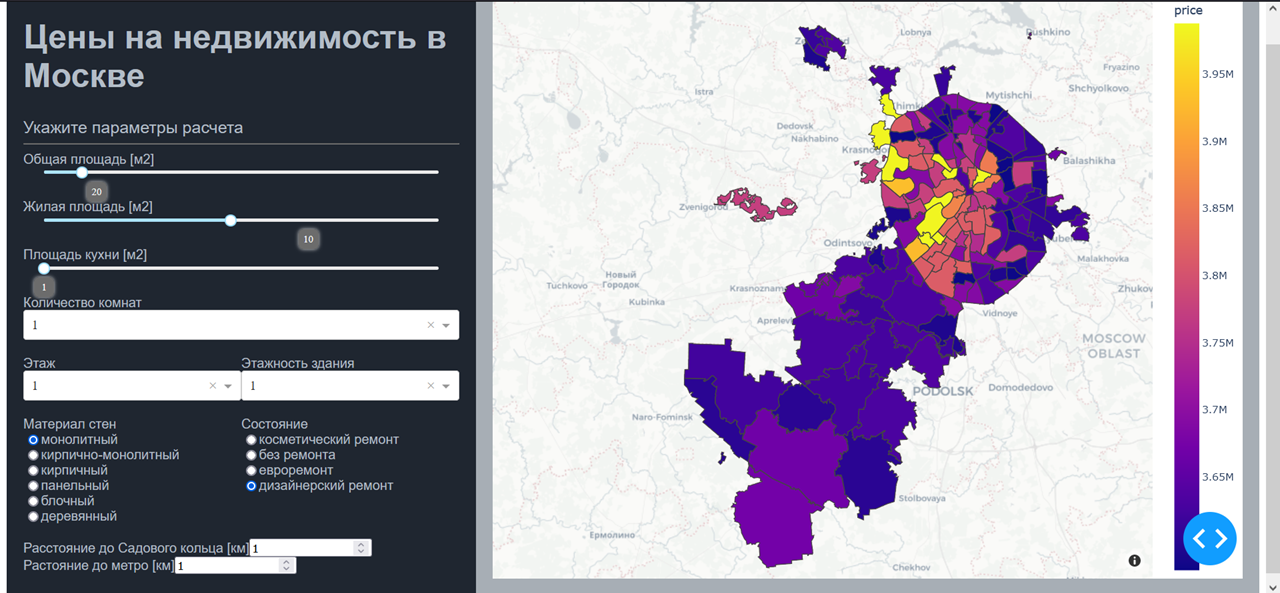